This script has the following objectives:  
- Computing the number of associated devices by minute
- Coming out with a count of associated devices

The principal aim is to filter out the associated devices and use that as a baseline to add on afterward...

In [90]:
from datetime import datetime 
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

In [91]:
def plot_2_ts(ts1, ts2):
    plt.figure(figsize=(12,5))
    plt.xlabel('Number of requests every 5 minutes')

    ax1 = ts1.plot(color='blue', grid=True, label='Algorithm')
    ax2 = ts2.plot(color='red', grid=True, secondary_y=False, label='Actual')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()


    plt.legend(h1+h2, l1+l2, loc=2)
    return plt

rounded_5 = lambda dt: datetime(dt.year, dt.month, dt.day,(dt.hour), 5*(round(dt.minute//5)))

In [92]:
%%bigquery df_farmboy_matrix
SELECT *
FROM  data-prod-270222.datascience.counting_baseline_clean
limit 100000

Downloading: 100%|██████████| 7972/7972 [00:00<00:00, 11524.06rows/s]


In [93]:
df_farmboy_matrix["local_minutes"] = df_farmboy_matrix["Timestamp"].apply(lambda x: datetime.utcfromtimestamp(x))
df_farmboy_matrix["local_minutes"] = df_farmboy_matrix["local_minutes"].apply(rounded_5)

df_poc = df_farmboy_matrix.groupby(['local_minutes']).nunique()[['device_mac']].iloc[1:-1,:]
df_poc = df_farmboy_matrix.groupby(['local_minutes']).device_mac.apply(np.array).to_frame().iloc[1:-1,:]
df_poc['device_mac'] = df_poc['device_mac'].apply(lambda x: np.unique(x))
df_poc['device_mac_shifted'] = df_poc['device_mac'].shift(1).fillna(0)

df_poc['in'] = df_poc.apply(lambda x: len(np.setdiff1d(x.device_mac, x.device_mac_shifted)), axis=1)
df_poc['out'] = df_poc.apply(lambda x: len(np.setdiff1d(x.device_mac_shifted, x.device_mac)), axis=1)
df_poc['cumul'] = df_poc['device_mac'].apply(lambda x: len(x))

In [99]:
df_validation = pd.read_csv(f'../validation_onroute.csv')

In [102]:
df_validation_5 = df_validation.groupby(np.arange(len(df_validation))//5).median().round()
df_validation_5[['In','Out']] = df_validation[['In','Out']].iloc[1:-1,:].groupby(np.arange(len(df_validation.iloc[1:-1,:]))//5).sum()

In [114]:
print(np.corrcoef(df_poc['cumul'], df_validation_5['Cumul'][1:]))
print(np.corrcoef(df_poc['in'], df_validation_5['In'][1:]))
print(np.corrcoef(df_poc['out'], df_validation_5['Out'][1:]))

[[1.         0.09086864]
 [0.09086864 1.        ]]
[[ 1.         -0.06891821]
 [-0.06891821  1.        ]]
[[1.         0.47926312]
 [0.47926312 1.        ]]


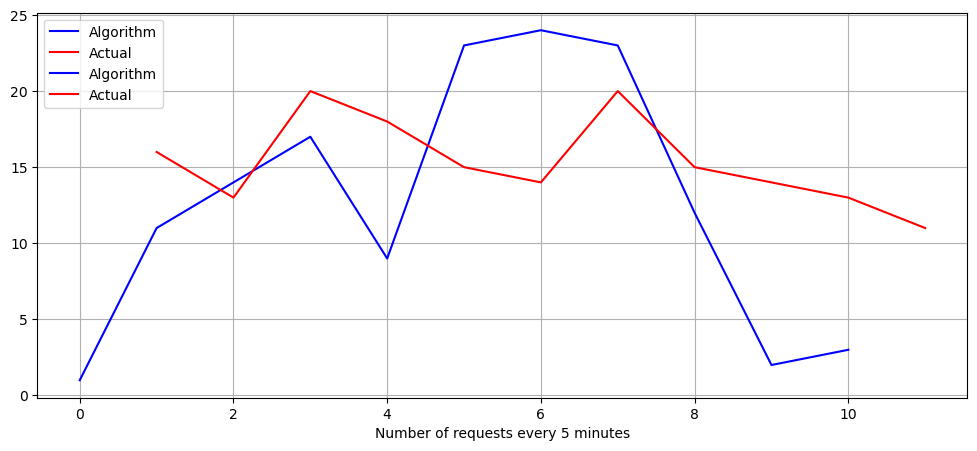

In [116]:
plot_2_ts(df_poc.reset_index()['out'],df_validation_5['Out'][1:]).show()

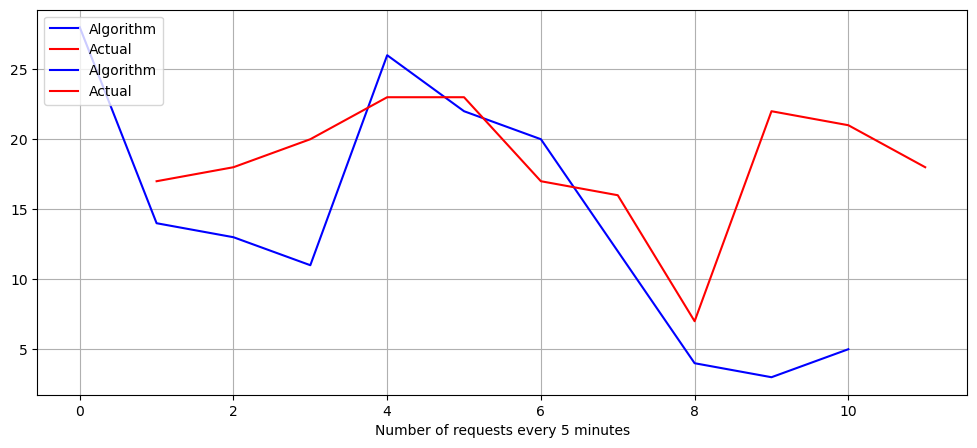

In [117]:
plot_2_ts(df_poc.reset_index()['in'],df_validation_5['In'][1:]).show()

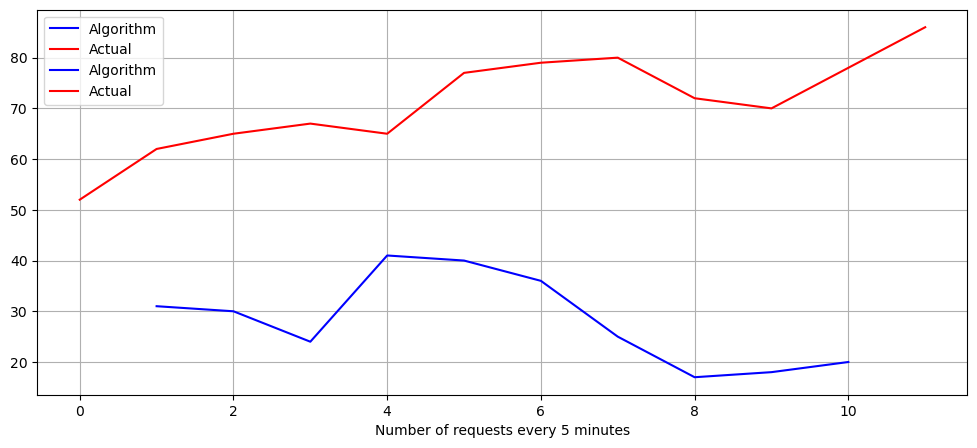

In [121]:
plot_2_ts(df_poc.reset_index()['cumul'][1:],df_validation_5['Cumul']).show()

In [122]:
print(mse(df_poc['cumul'], df_validation_5['Cumul'][1:], squared=False))
print(mse(df_poc['in'], df_validation_5['In'][1:], squared=False))
print(mse(df_poc['out'], df_validation_5['Out'][1:], squared=False))

45.81484475582123
10.539967224375467
7.6988783126327744


In [123]:
print(mape(df_poc['cumul'], df_validation_5['Cumul'][1:]))
print(mape(df_poc['in'], df_validation_5['In'][1:]))
print(mape(df_poc['out'], df_validation_5['Out'][1:]))

1.8144525426697873
1.4879332788423698
2.3250009310227866


In [124]:
df_poc.mean()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


in       14.363636
out      12.636364
cumul    28.181818
dtype: float64

In [125]:
df_poc.sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


in       158
out      139
cumul    310
dtype: int64

In [126]:
df_validation_5.sum()

In       224.0
Out      181.0
Cumul    853.0
dtype: float64

In [127]:
df_validation_5.mean()

In       18.666667
Out      15.083333
Cumul    71.083333
dtype: float64

In [128]:
len(set(df_farmboy_matrix['device_mac']))

168

Devices farmboy = 232

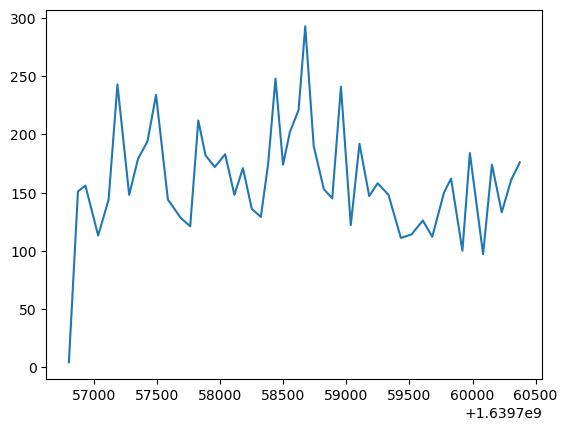

In [147]:
plt.plot(df_farmboy_matrix.groupby('Timestamp').count()['device_mac'].rolling(5,min_periods=1).mean().iloc[::50].index,df_farmboy_matrix.groupby('Timestamp').count()['device_mac'].rolling(50,min_periods=1).sum().iloc[::50])
plt.show()

In [148]:
df_farmboy_matrix.groupby('Timestamp').count()['device_mac'].rolling(10,min_periods=1).sum().mean()

32.89665150888797